<a href="https://colab.research.google.com/github/hukim1112/one-day-LLM-FT/blob/main/Fine_tuning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

### 언어 모델 동작 이해

언어모델의 데이터 처리를 이해하기 위해 huggingface 모델의 동작 방식을 깊게 살펴보겠습니다.

- Tokenizer : 원시 텍스트를 token sequence로 변환.
- Model : Bert나 GPT 같은 transformer 기반의 언어모델
    - Backbone : token sequence를 입력 받아 그들의 context를 바탕으로 새로운 token embedding을 계산
    - Head : 문제에 맞게 token embedding으로부터 정답을 추론

- Post processing : 사람에게 친숙한 형태로 추론을 표현

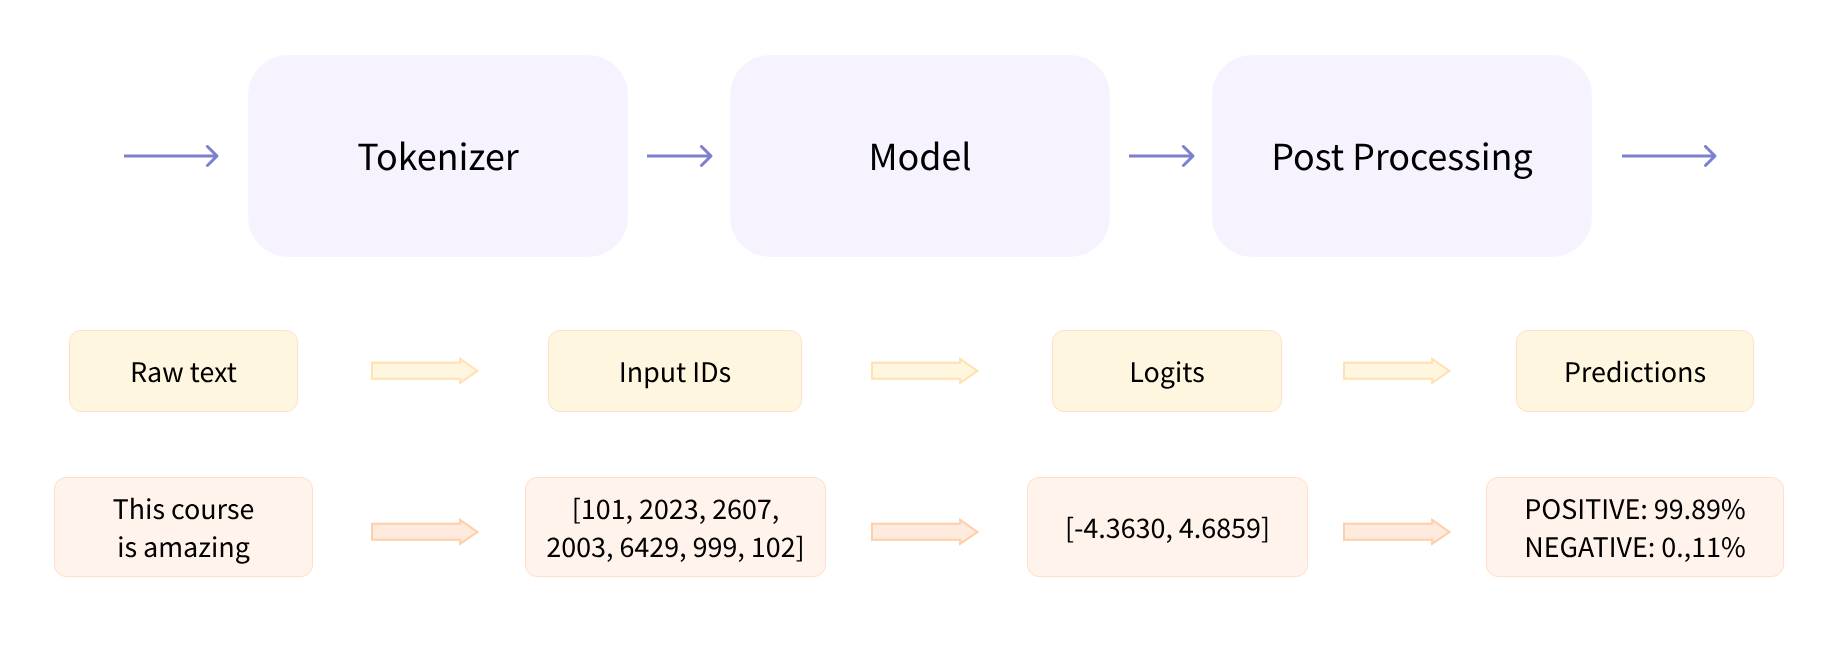

### 토크나이저

Hugging Face는 다양한 언어와 목적에 맞는 많은 tokenizer를 제공하고 있습니다. 한국어를 포함한 다양한 언어에 대한 fine-tuning을 위해, Hugging Face의 tokenizer 라이브러리인 transformers를 사용할 수 있습니다.

다른 신경망과 마찬가지로 트랜스포머 모델도 원시 텍스트(raw text)를 직접 처리할 수 없으므로 파이프라인의 첫 단계는 텍스트 입력을 모델이 이해할 수 있는 숫자로 변환합니다. 이를 위해 토크나이저를 사용하는데, 이는 다음 세 가지 역할을 합니다:

- tokenization : 입력을 단어, 부분 단어 또는 기호(구두점과 같은)로 분할하여 토큰이라고 부릅니다.
- integer coding : 각 토큰을 정수에 매핑합니다.
- 그 외 모델에 유용할 수 있는 특수 토큰 추가(SOS, EOS 등등)

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

input_ids는 각 문장의 토큰을 고유하게 식별하는 정수들입니다.

In [ ]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
    "I want to learn LLM based agent system",
    "한국어도 이해하나요?"
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

In [ ]:
inputs['input_ids'] #두 문장에 대한 integer code

In [ ]:
tokenizer.decode(inputs['input_ids'][0])

In [ ]:
tokenizer.decode(inputs['input_ids'][1])

In [ ]:
tokenizer.batch_decode(inputs['input_ids'])

### Model

우리는 토크나이저와 유사하게 AutoModel 클래스로 사전 훈련된 모델을 다운로드할 수 있습니다.

모델은 embedding layer, backbone, head network로 구성됩니다.
- embedding layer는 토큰화된 입력에서 각 입력 ID를 관련 토큰을 나타내는 벡터로 변환합니다.
- backbone은 입력 토큰의 새로운 임베딩 표현을 계산합니다. 초기 토큰 임베딩은 문장의 맥락을 고려하지 않은 학습된 토큰의 표현입니다. 그러나 backbone을 통해 토큰은 함께 입력된 문장의 문맥을 고려해 새로운 토큰 임베딩으로 변환됩니다. 궁극적으로 이는 추론 정확성을 향상시키기 위한 것입니다.
- transformer는 작업에 따라 결론을 내는 부분인 Head network가 달라집니다.



In [ ]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

In [ ]:
model

각 차원은 출력은 [배치사이즈, 시퀀스 길이, 임베딩 차원]의 shape을 갖습니다.

In [ ]:
inputs

In [ ]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

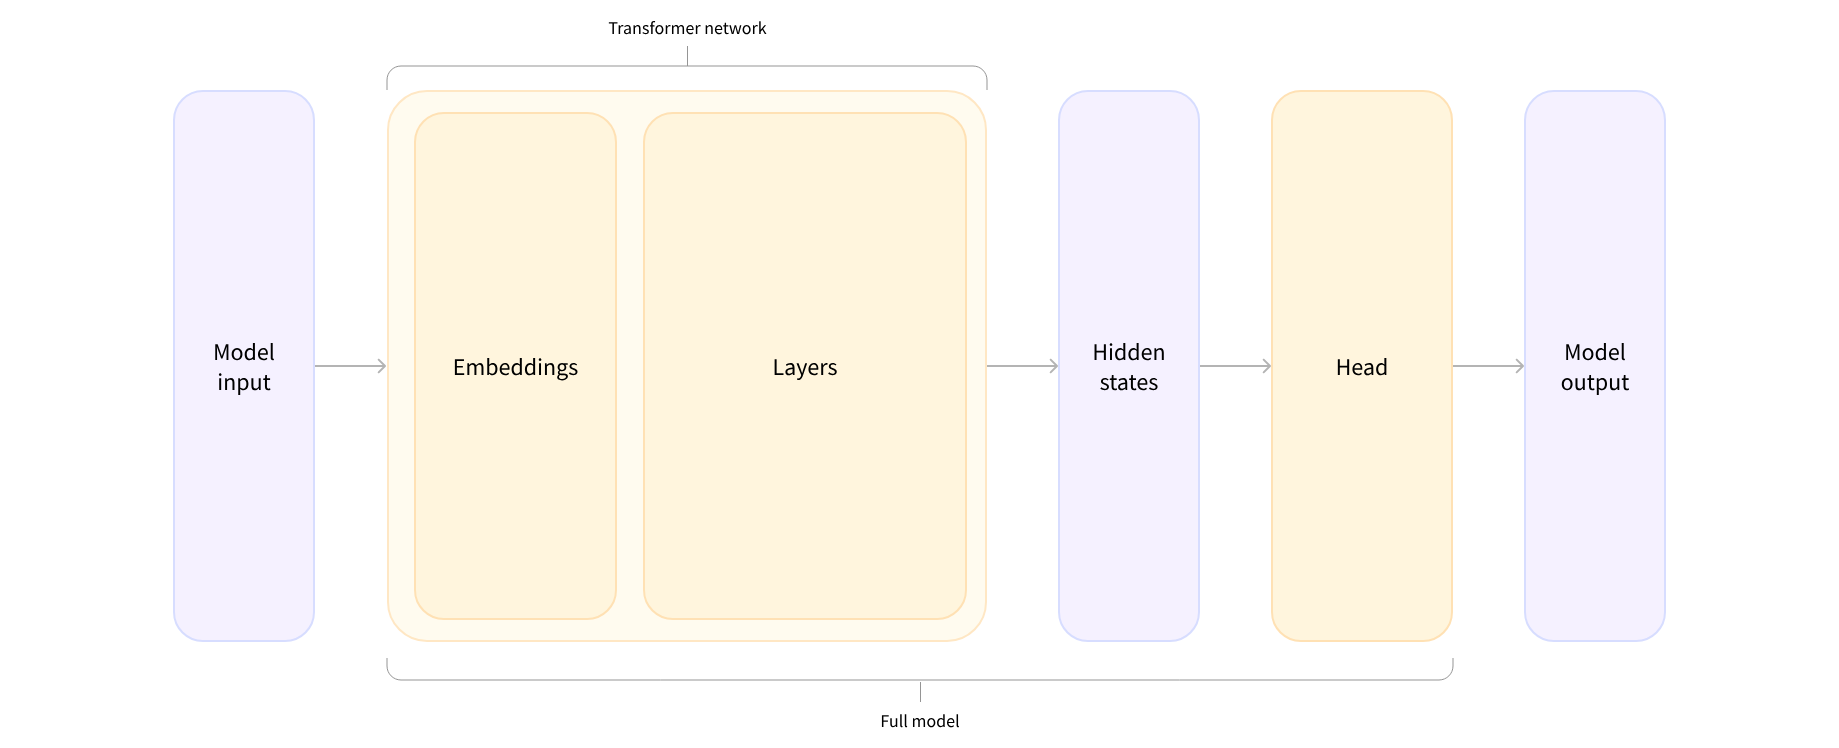



Huggingface는
문제에 따라 transformer를 쉽게 활용하도록 다음 class를 제공합니다.

- ForCausalLM
- ForMaskedLM
- ForMultipleChoice
- ForQuestionAnswering
- ForSequenceClassification
- ForTokenClassification

문장 분류 문제를 위해 AutoModelForSequenceClassification을 사용해보겠습니다. 우리가 사용할 distilbert는 해당 task에 대해 사전학습되어있기 때문에 backbone 뿐만 아니라 pretrained head가 함께 불러와집니다.

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

In [ ]:
print(outputs.logits.shape)

In [ ]:
print(outputs.logits)

우리 모델은 첫 번째 문장에 대해 [-1.5607, 1.6123]을, 두 번째 문장에 대해 [4.1692, -3.3464]를 예측했습니다. 이것들은 확률이 아니라 logits입니다. logits은 모델의 마지막 층에서 출력된 원시, 정규화되지 않은 점수(score)입니다.

확률로 변환하려면 softmax를 거쳐야 합니다. transformers 모델은 모두 logits를 출력하며, 손실 함수는 보통 softmax를 이미 포함하고 있기 때문에 별로로 softmax layer를 사용하지 않습니다.

In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

In [ ]:
predictions = torch.nn.functional.softmax(torch.tensor([-1.0, -3.0]))
predictions

In [ ]:
model.config.id2label

이제 모델이 다음과 같이 예측했다고 결론지을 수 있습니다:

First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598

Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005



# Fine-tune a pretrained model


파인튜닝(Fine-tuning)은 사전 훈련된 모델을 특정 작업에 맞게 조정하여 성능을 최적화하는 과정입니다. 이는 모델이 이미 축적한 일반적인 지식을 바탕으로, 주어진 작업에 특화된 데이터셋에서 추가 학습을 진행하는 것을 의미합니다. 파인튜닝은 처음부터 모델을 학습시키는 것보다 비용과 시간 측면에서 훨씬 효율적이며, 다양한 응용 분야에 맞는 맞춤형 성능을 제공합니다. 이 튜토리얼에서는 PyTorch와 Hugging Face 두 가지 접근 방식을 사용하여 사전 훈련된 모델을 파인튜닝하는 과정을 소개합니다.



## Pytorch를 사용한 학습

### 데이터 파트

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc")

glue 데이터의 서브 데이터셋인 mrpc, The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005)를 huggingface hub로부터 가져옵니다. mrpc는 아래와 같은 구성을 갖고 있습니다.

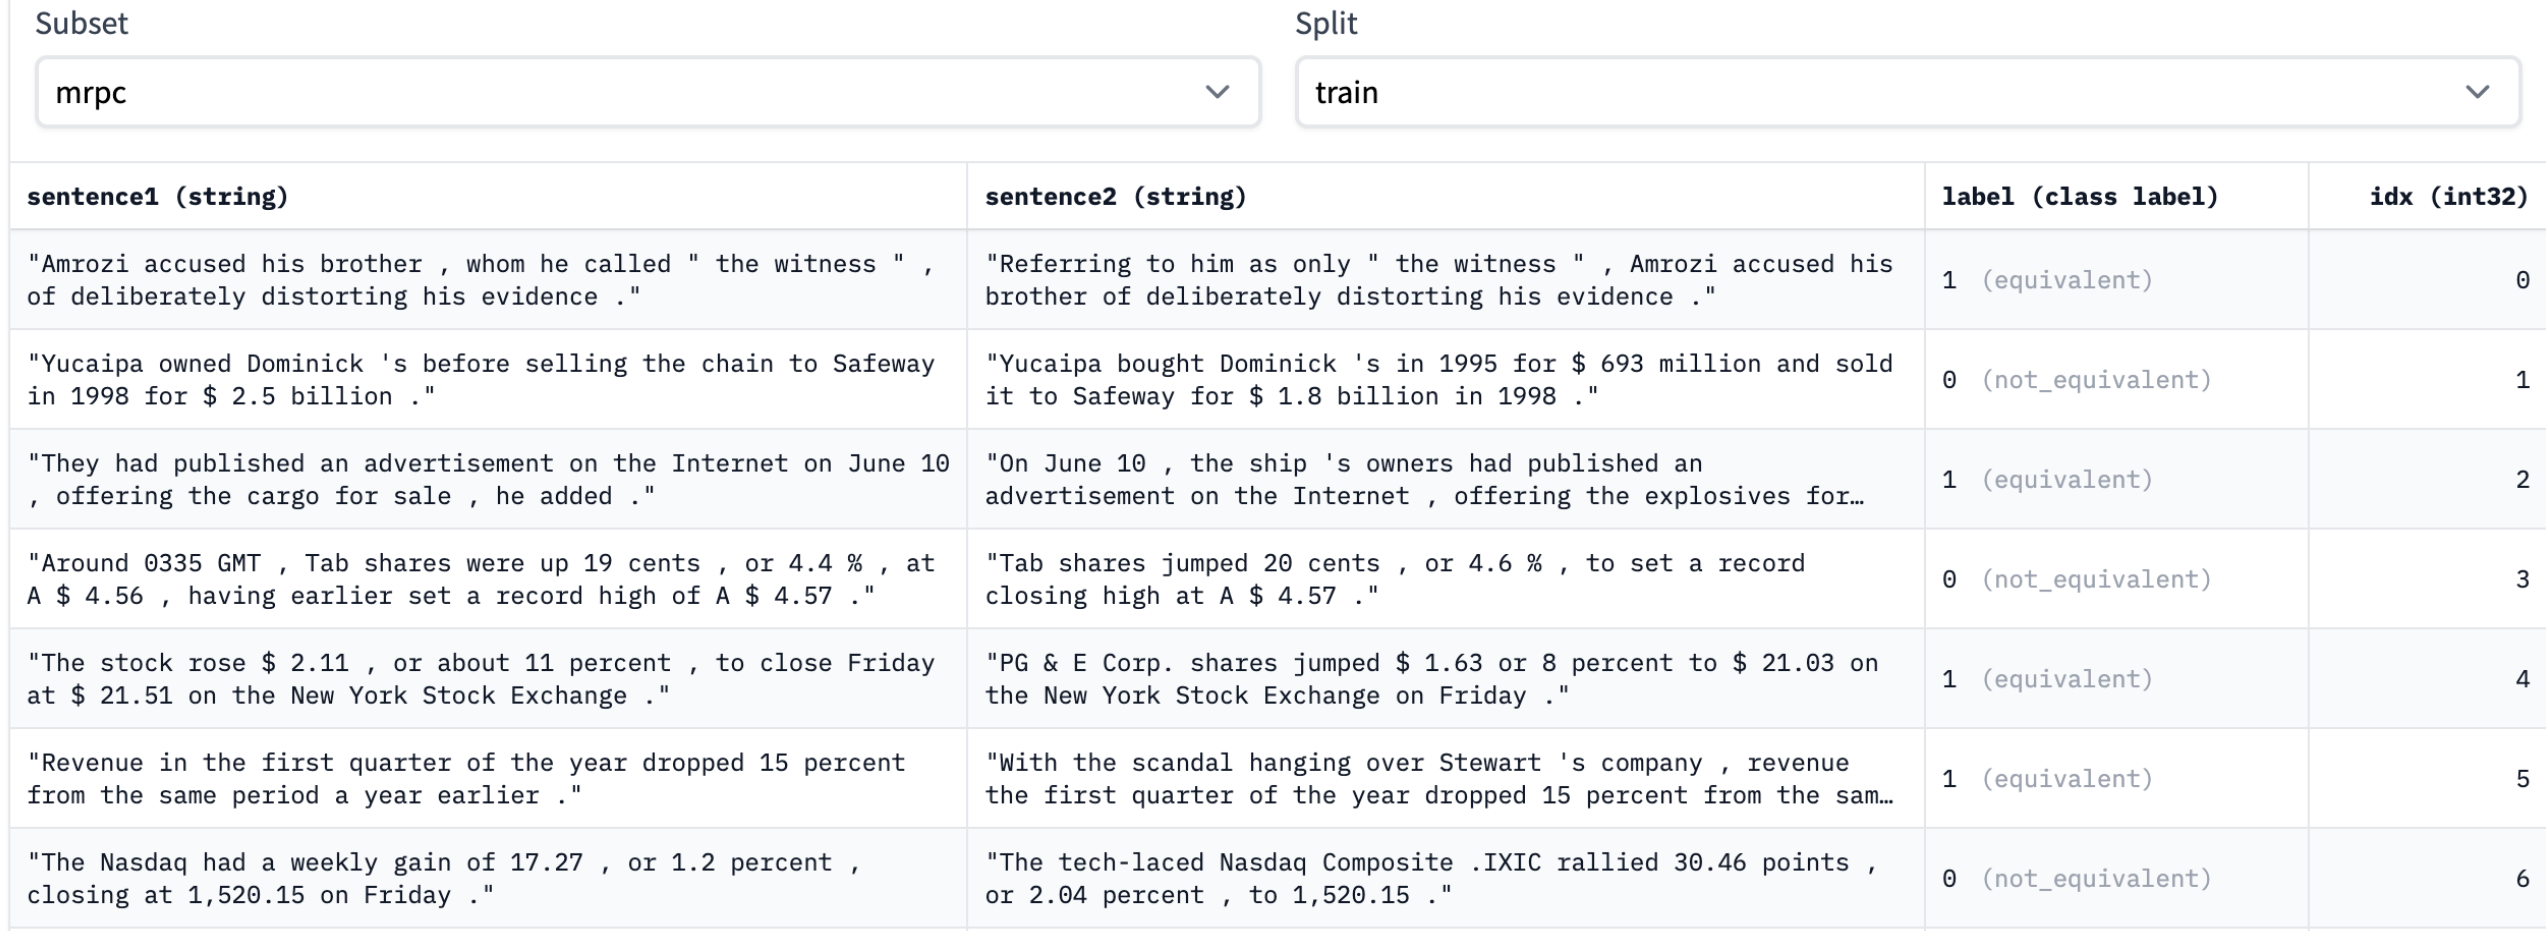

In [ ]:
raw_datasets

허깅페이스 데이터셋 클래스인 DatasetDict는 데이터 스플릿으로 나뉘어있습니다. 또한 각 스플릿의 feature와 수량을 확인할 수 있습니다.

이제 언어모델이 입력 받을 수 있도록 토크나이저를 사용해 전처리를 수행하겠습니다. 데이터셋의 map 함수를 사용하면 효과적으로 전처리할 수 있습니다.

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
#토크나이저 로드: 설정한 체크포인트를 기반으로 토크나이저를 로드합니다. 이 토크나이저는 BERT 모델에 맞게 텍스트를 토큰 단위로 변환해줍니다.

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
#데이터셋 토크나이즈: map 메서드를 이용하여 데이터셋의 각 샘플에 tokenize_function을 적용해 토크나이즈된 데이터셋을 생성합니다. batched=True로 설정하여 배치 단위로 처리합니다.



데이터 콜레이터는 허깅페이스에서 데이터 전처리를 위해 사용하는 중요한 유틸러티 클래스입니다. 허깅페이스 데이터셋을 배치사이즈 별로 batching하기 위해 패딩을 적용하고, SSL 학습이 가능한 문제에서는 label 생성의 역할까지 합니다.

In [ ]:
tokenized_datasets

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# 모델이 원시 텍스트를 입력으로 받지 않으므로 텍스트 열을 제거합니다:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])

# 모델이 인자를 'labels'로 명명된 상태로 기대하므로 'label' 열의 이름을 'labels'로 변경합니다:
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# 데이터셋의 형식을 리스트 대신 PyTorch 텐서를 반환하도록 설정합니다:
tokenized_datasets.set_format("torch")

# 학습 데이터셋의 열 이름을 출력합니다:
tokenized_datasets["train"].column_names


In [ ]:
tokenized_datasets

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

In [ ]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

레이블을 확인합니다.

In [ ]:
batch['labels']

패딩처리된 input ids를 확인합니다.

In [ ]:
batch['input_ids']

tokenizer로 decoding하여 원본 텍스트로 복원하여 데이터 전처리  결과를 확인해 봅니다.

In [ ]:
tokenizer.batch_decode(batch['input_ids'])

### 모델 파트

모델의 구조는 문제에 맞게 다시 구조화될 필요가 있습니다. 사전학습 모델의 능력을 활용하면서도 문제를 풀기 위해 우리는 head network를 문제에 맞게 추가해 학습합니다.

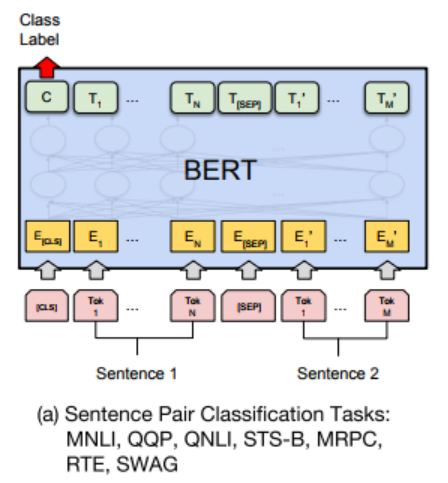

from_pretrained 메서드를 사용하여 사전 학습된 모델을 불러옵니다. checkpoint는 이전에 설정한 모델의 체크포인트(예: "bert-base-uncased")를 가리킵니다.
num_labels=2는 분류 작업에서 사용할 클래스의 수를 설정합니다. 예를 들어, 이 코드에서는 이진 분류 작업(두 개의 클래스)을 수행하기 위해 num_labels를 2로 설정합니다.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [ ]:
model

outputs.loss는 모델의 손실 값을 나타냅니다. 손실 값은 모델의 예측이 실제 값과 얼마나 차이가 있는지를 나타내는 지표로, 모델을 훈련시키는 과정에서 최소화하려고 합니다.
outputs.logits는 모델의 예측값(로짓)입니다. 로짓은 각 클래스에 대한 모델의 확신도를 나타내며, 보통 소프트맥스 함수를 통해 확률로 변환됩니다.

In [ ]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

### 학습 파트

transformers 라이브러리에서 AdamW 옵티마이저를 임포트합니다.
모델의 파라미터를 입력으로 받아 학습률을 5e-5로 설정한 AdamW 옵티마이저를 생성합니다.

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

get_scheduler를 임포트하여 학습률 스케줄러를 설정합니다.
num_epochs를 3으로 설정하고, 전체 학습 스텝 수를 계산합니다.
선형 스케줄러를 생성하여 지정된 학습 스텝 동안 학습률을 조정합니다.

In [ ]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

모델을 학습 모드로 전환한 후, 에포크 수만큼 반복합니다.

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss #모델에 전달하여 손실을 계산
        loss.backward() # 역전파를 수행

        optimizer.step() #옵티마이저 업데이트
        lr_scheduler.step() #학습률 스케줄러 업데이트
        optimizer.zero_grad()
        progress_bar.update(1)

모델을 평가 모드로 전환한 후, metric을 계산합니다.

In [ ]:
import evaluate

metric = evaluate.load("glue", "mrpc")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

accelerator 사용

Accelerate 라이브러리는 Hugging Face에서 제공하는 라이브러리로, 모델 학습을 가속화하고 PyTorch 기반의 분산 학습을 쉽게 구현할 수 있도록 도와줍니다.

In [ ]:
from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

accelerator = Accelerator()

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

num_epochs = 3
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dl:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

## Transformer Trainer API 사용

다음으로 Trainer API를 활용해 [glue 데이터셋](https://huggingface.co/datasets/nyu-mll/glue)의 mrpc 데이터셋을 학습해봅시다!

🤗 Transformers는 모델의 훈련을 최적화한 [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) 클래스를 제공하여, 직접 훈련 루프를 작성하지 않고도 쉽게 훈련을 시작할 수 있습니다. [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) API는 로깅, 그래디언트 축적, 혼합 정밀도 등 다양한 훈련 옵션과 기능을 지원합니다.

GLUE (General Language Understanding Evaluation) 벤치마크는 여러 다른 NLP 작업을 포함한 데이터셋 모음으로, 이 중 mrpc는 문장 쌍이 서로 의미상으로 동일한지를 판단하는 작업

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Training hyperparameters

다음으로, 다양한 하이퍼파라미터와 여러 훈련 옵션을 활성화하는 플래그들을 포함하는 [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) 클래스를 생성합니다. 이 튜토리얼에서는 기본 훈련 [하이퍼파라미터](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)로 시작할 수 있지만, 최적의 설정을 찾기 위해 이를 실험해 보아도 좋습니다.

훈련 과정에서 생성된 체크포인트를 저장할 위치를 지정하세요:

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")
training_args.report_to = ['tensorboard'] #['tensorboard', 'wandb']. not use wandb in this experiment.

In [ ]:
training_args

모델을 로드하고 예상 레이블 수를 지정합니다.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

In [ ]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

In [ ]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

### Evaluate

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer)는 훈련 중 자동으로 모델 성능을 평가하지 않습니다. 성능을 계산하고 보고할 함수를 [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer)에 전달해야 합니다. [🤗 Evaluate](https://huggingface.co/docs/evaluate/index) 라이브러리는 간단한 다양한 평가 함수를 제공하며, 이를 [evaluate.load](https://huggingface.co/docs/evaluate/main/en/package_reference/loading_methods#evaluate.load) 함수로 로드할 수 있습니다. 자세한 내용은 이 [quicktour](https://huggingface.co/docs/evaluate/a_quick_tour)를 참조하세요:

In [ ]:
import evaluate

metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

In [ ]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Trainer

다음으로, 모델, 훈련 인자, 훈련 및 테스트 데이터셋, 평가 함수를 포함하여 Trainer 객체를 생성합니다:

In [ ]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
training_args.report_to = ['tensorboard'] #['tensorboard', 'wandb']
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()